In [1]:
import sys
sys.path.append(r"/home/vidarmarsh/CEZ_Mapping")

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from Python.data_generator import generate_image_dataset_from_files
from Python.data_generator import Data_Generator
from Python.segmentation_model import deeplabv3plus
from Python.utils import get_png_paths_from_dir
from Python.utils import load_weight_map
from Python.model_tools import load_model
from Python.utils import write_model_to_disk
from Python.data_pipeline import split_dataset
from Python.model_tools import compare_model_predictions
from Python.data_pipeline import augment_dataset
from Python.config import Config

print(tf.config.list_physical_devices('GPU'))

2023-03-28 15:57:42.000915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:57:44.298630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-03-28 15:57:44.298833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-03-28 15:57:44.298842: W tens

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-28 15:57:46.280990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:57:46.313466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:57:46.313514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
image_files = get_png_paths_from_dir(Config.image_path)
mask_files = get_png_paths_from_dir(Config.segmentation_path)
weight_map = load_weight_map(Config.weight_map_path)
weights = np.zeros(Config.output_channels, dtype=float)
for key in weight_map.keys():
    weights[int(key)] = weight_map.get(key)

dataset = generate_image_dataset_from_files(
    image_files, 
    mask_files, 
    Config.batch_size, 
    Config.shuffle_size, 
    weights
)
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset, Config.train_size, Config.val_size, Config.test_size
)
# train_dataset = augment_dataset(train_dataset)

2023-03-28 15:57:46.353690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:57:46.359426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:57:46.359480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:57:46.359504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
model = deeplabv3plus(
  Config.input_shape, 
  Config.batch_size, 
  Config.output_channels,
  Config.channels_low,
  Config.channels_high,
  Config.middle_repeat
)
model.compile(
  optimizer='adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ["accuracy"]
)

In [4]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(model, dataset=None, num=1):
  for image, mask, weight in iter(dataset.take(num)):
    compare_model_predictions(model, image[0], mask[0])

1/1 [==============================] - 0s 33ms/step


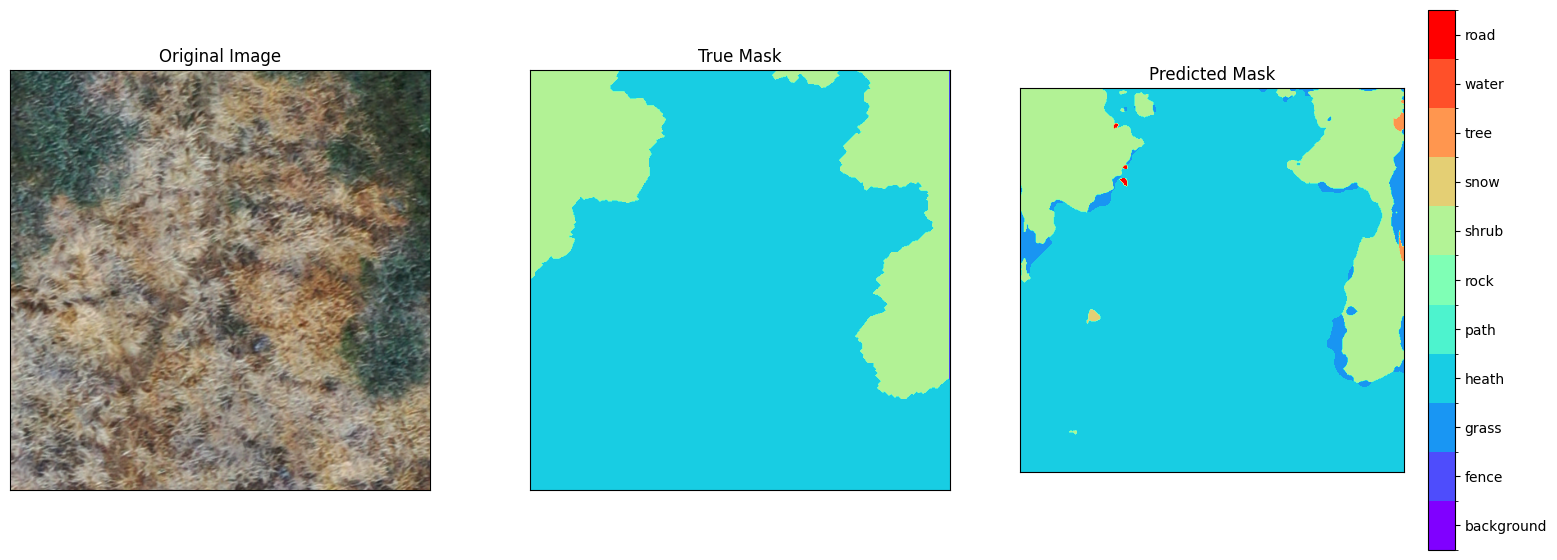

In [24]:
show_predictions(model, dataset, num=1)

In [6]:
model_history = model.fit(
  train_dataset, 
  epochs=20,
  validation_data=val_dataset,
  shuffle=True
)

Epoch 1/20


2023-03-28 15:58:18.455446: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f475221dea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-28 15:58:18.455523: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-03-28 15:58:18.479647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-28 15:58:18.715437: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

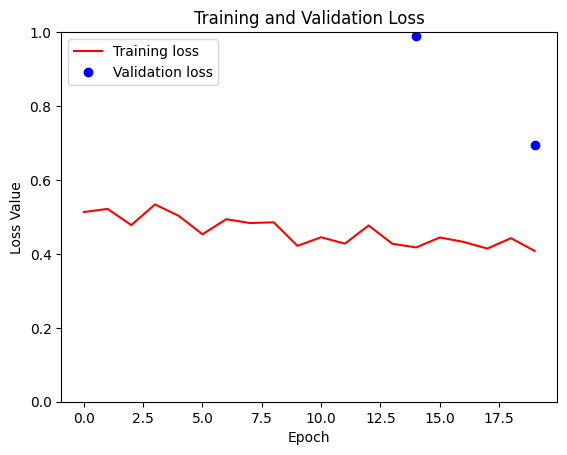

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
write_model_to_disk(model, model_history, Config)

INFO:tensorflow:Assets written to: /home/vidarmarsh/CEZ_Mapping/Data_combined/Models/5/model/assets


INFO:tensorflow:Assets written to: /home/vidarmarsh/CEZ_Mapping/Data_combined/Models/5/model/assets
